# Bicycle Sharing

### Business Understanding
This project will predict the rental count of bicycles on an hourly or daily basis, taking into account environmental and seasonal changes. 

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [239]:
df = pd.read_csv('train_bikes.csv')
test = pd.read_csv('test_bikes.csv')
submission = pd.read_csv('sampleSubmission.csv')

### 1. Initial Data Understanding

In [240]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [152]:
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [153]:
# Checking variable types
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [154]:
# Looking at data summary
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


<ins>Windspeed</ins> <br> The max wind speed is 57. Assuming the number is in mph, it's worth checking when that day was <br> and how many people rented a bike as well as if there was a weather disaster of some sort

In [155]:
# Checking for any null values
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### 2. Data Preparation & Visualizations

In [156]:
# Convert datetime object to type: datetime
# Extract month, day, and hour for further analysis
df.datetime = pd.to_datetime(df.datetime)
df['month'] = df.datetime.dt.month
df['dayofweek'] = df.datetime.dt.dayofweek
df['hour'] = df.datetime.dt.hour
df = df.drop(columns = ['datetime'])


test.datetime = pd.to_datetime(test.datetime)
test['month'] = test.datetime.dt.month
test['dayofweek'] = test.datetime.dt.dayofweek
test['hour'] = test.datetime.dt.hour
test = test.drop(columns = ['datetime'])

In [157]:
# Reassigning 'season' variable. Seaons are assigned to wrong months
# Changing to 'Spring' = 'Month 3-5', 'Summer' = 'Month 6-8', 'Fall' = 'Month 9-11', 'Winter' = 'Month 12-2'

# Create dictionary for seasons corresponding to months
season_dict = {12:"winter", 1:'winter', 2:"winter",
               3:"spring", 4:'spring', 5:"spring",
               6:"summer", 7:'summer', 8:"summer",
               9:"fall", 10:'fall', 11:"fall"}

# Use pd.map to change values with dictionary
df['season'] = df['month'].map(season_dict)

test['season'] = test['month'].map(season_dict)

<AxesSubplot:xlabel='hour', ylabel='count'>

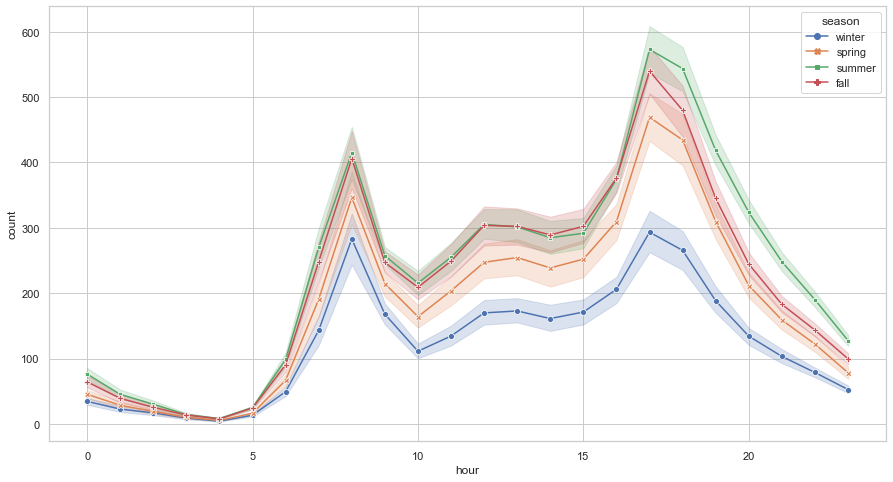

In [158]:
# Lineplot count vs hour separated by season
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style('whitegrid')
sns.lineplot(data = df, x = 'hour', y = 'count', hue = 'season', style = 'season',
            markers = True, dashes = False) # 'style' and 'markers' or dots, 'dashes' for line type

We can see here that the number of riders begin to increase sharply at around the 6am mark and start to decrease past the 5pm mark. The plots indicate a bimodal distribution depict when people use the bikes the most, which is in line with rush hour. At 10 am, the count begins to increase again, which could be caused by a number of reasons, some of which potentially being different work start times or people using bicycles to move to their next destination. We also see that Summer and Spring share similar count values, with Winter being drastically lower than that of the other seasons. When comparing seasons, the peak at 5pm is much lower than it is at 8am. This could be because people choose to take less tiring and warmer methods of transportation when going home from work.

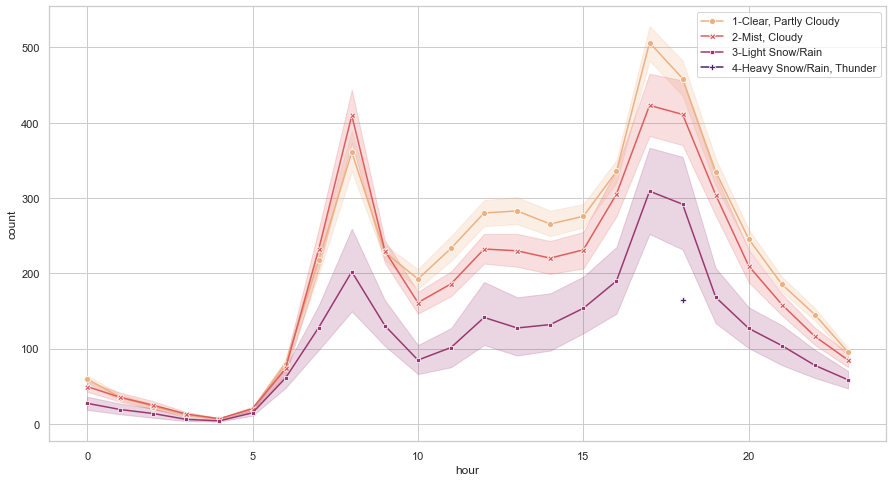

In [159]:
sns.set(rc = {'figure.figsize': (15,8)})
sns.set_style('whitegrid')
sns.lineplot(data = df, x = 'hour', y = 'count', hue = 'weather', style = 'weather', 
            markers = True, dashes = False, palette = 'flare')
plt.legend(labels = ['1-Clear, Partly Cloudy', '2-Mist, Cloudy', '3-Light Snow/Rain', '4-Heavy Snow/Rain, Thunder'])

We see many similarities from the plot above, where the bimodal distribution peaks are at 8am and 5pm and the number of overall riders decrease as the weather conditions worsen. The difference between weather conditions are more drastic compared to the seasons. We also see that there is a single point at around 6pm where people rented bikes during a heavy snow/rain or thunderstorm.

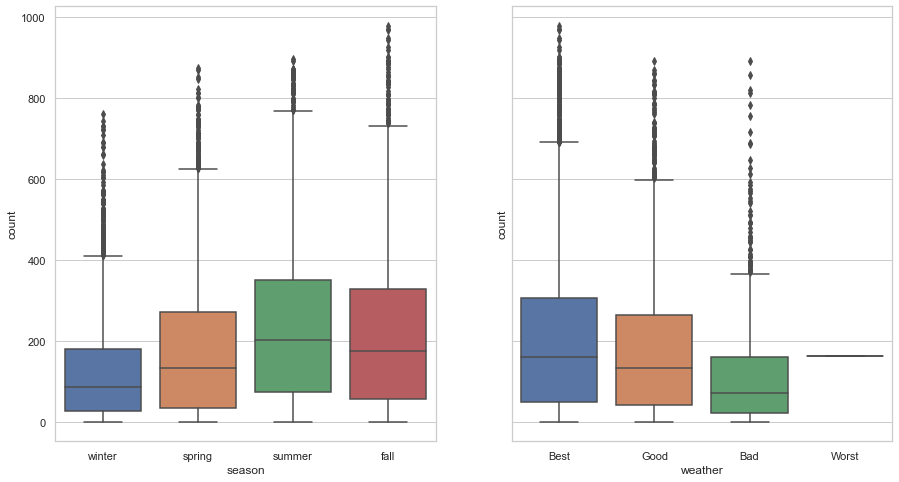

In [160]:
fig, axes = plt.subplots(1, 2, figsize = (15,8), sharey = True)
ax = sns.boxplot(ax = axes[0], data = df, y = 'count', x = 'season')
ax1 = sns.boxplot(ax = axes[1], data = df, y = 'count', x = 'weather')
ax1.set_xticklabels(['Best','Good','Bad', 'Worst'])
plt.show()

In [161]:
# Checking rider count when the weather = 4 (Heavy Snow, Rain, Thunderstorm)
df.iloc[np.where(df['weather'] == 4)]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,dayofweek,hour
5631,winter,0,1,4,8.2,11.365,86,6.0032,6,158,164,1,0,18


<ins>Season</ins><br>
The plot on the right shows that the number of riders is obviously the lowest in the Winter, with Summer and Fall having the highest and largest median and IQR values, respectively. It's interesting to note that there are many outliers past the upper fence and that the colder seasons have more outliers than the warmer seasons. This observation does make sense, in that there will always some people who need to use the bikes regardless of the weather.
<br><br>
<ins>Weather</ins><br>
We see that the IQR and median is the largest for the best weather, followed by the good and bad. While we can't obviously tell which weather condition has the most outliers, we can safely conclude that the bad weather condition days have the largest range of outliers. This makes logical sense, in that despite weather conditions, some people need to use the bikes to get around the city. We can also see that there is one day where riders chose to rent bikes when the weather condition was at its absolute worst. A quick search showed a very brief moment on 01/09/2012 where 1-2 inches of snow fell.

<AxesSubplot:xlabel='month', ylabel='count'>

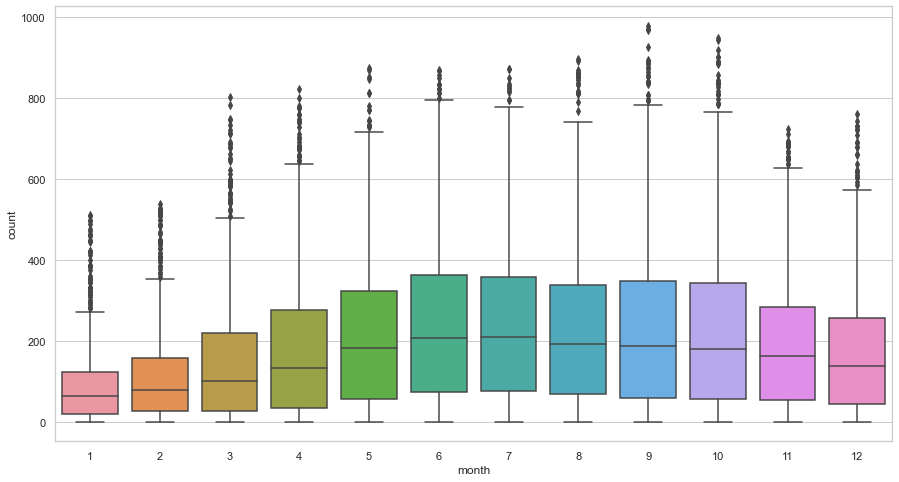

In [162]:
sns.boxplot(data = df, y = 'count', x = 'month')

<function matplotlib.pyplot.show(close=None, block=None)>

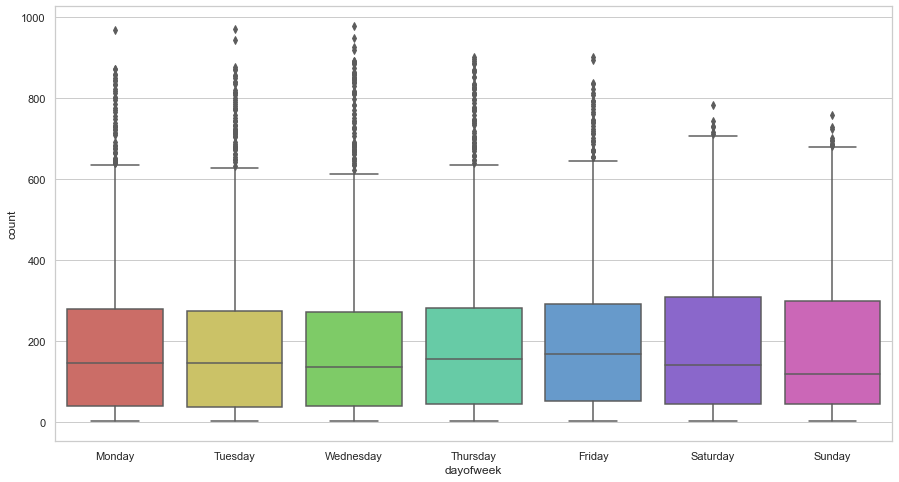

In [163]:
ax2 = sns.boxplot(data = df, y = 'count', x = 'dayofweek', palette = 'hls')
ax2.set_xticklabels(['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show

<AxesSubplot:xlabel='hour', ylabel='count'>

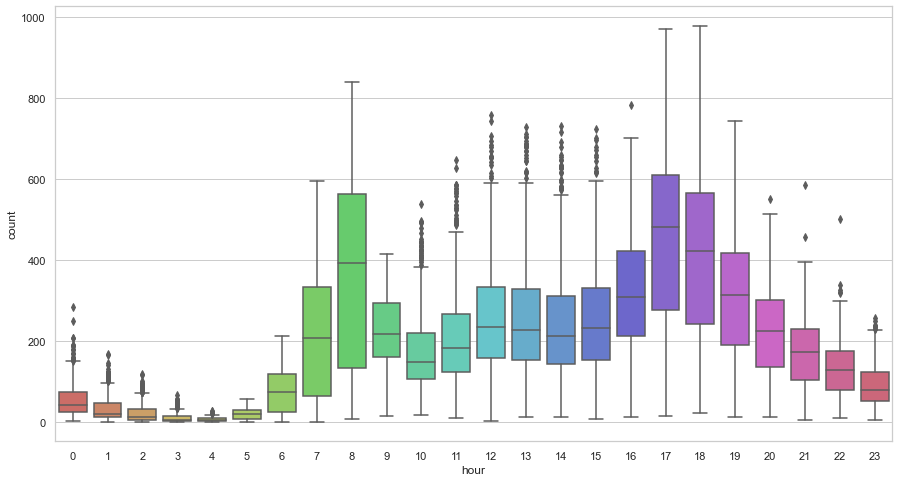

In [164]:
sns.boxplot(data = df, y = 'count', x = 'hour', palette = 'hls')

<AxesSubplot:xlabel='windspeed', ylabel='count'>

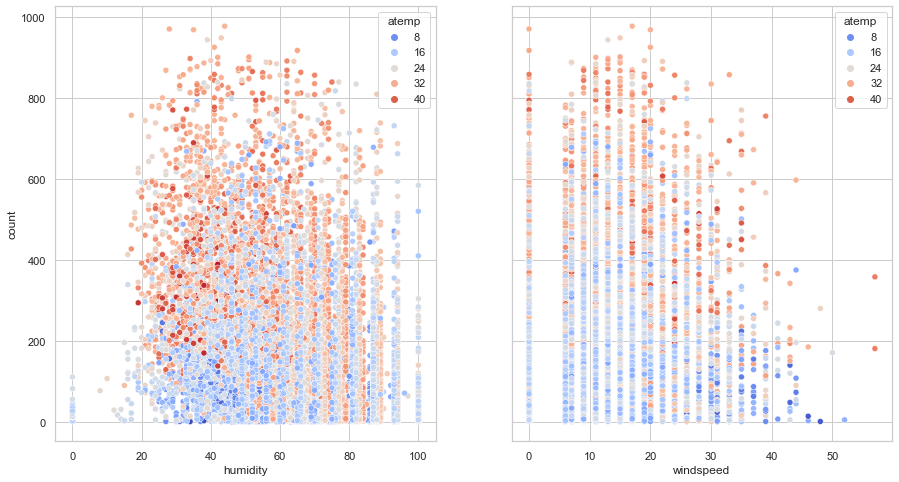

In [165]:
fig, axes = plt.subplots(1,2, figsize = (15,8), sharey = True)
sns.scatterplot(ax = axes[0], data = df, y = 'count', x = 'humidity', hue = 'atemp',
               palette = 'coolwarm')
sns.scatterplot(ax = axes[1], data = df, y = 'count', x = 'windspeed', hue = 'atemp',
               palette = 'coolwarm')

<ins>Humidity</ins><br>
Judging from the graph on the left, the riders seem to have a slight preference to bike when the humidity is lower, though the difference isn't as apparent as the scatterplot with windspeed. We can also see that when people choose to ride on days where the humidity is at or close to 100, it's almost always on cooler temperatures (~16C), which makes sense considering how humidity severely affects the perceived temperature.
<br><br>
<ins>Windspeed</ins><br>
We can clearly see that the number of riders significantly decrease once the windspeed passes 35 km/hr. The difference in the count of riders when the temperature is hot vs cold is also very apparent, depicted by the gradient from orange down to blue. We can also see some outliers all the way on the right side, where the windspeed is close to 0 and the temperature is ~32C.

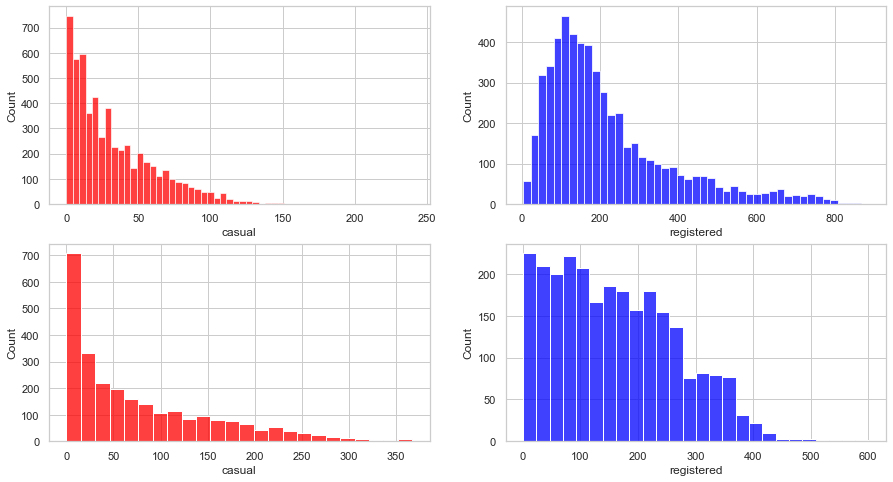

In [166]:
# Casual vs Registered based on Workingday
# Chose hour range from 7am to 11pm inclusive to decrease amount of 0 riders
casual_regis_work_no = df.iloc[np.where((df.hour >= 6) & (df.hour <= 23) & (df.workingday == 0))]
casual_regis_work_yes = df.iloc[np.where((df.hour >= 6) & (df.hour <= 23) & (df.workingday == 1))]
fig, axes = plt.subplots(2, 2, figsize = (15,8), sharey = False)
sns.histplot(ax = axes[0,0], data = casual_regis_work_yes, x = 'casual', color = 'red')
sns.histplot(ax = axes[0,1], data = casual_regis_work_yes, x = 'registered', color = 'blue')
sns.histplot(ax = axes[1,0], data = casual_regis_work_no, x = 'casual', color = 'red')
sns.histplot(ax = axes[1,1], data = casual_regis_work_no, x = 'registered', color = 'blue')
plt.show()

In [167]:
# Removing outliers
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
df = df.iloc[np.where(df['count'] < upper)]

In [168]:
# Create dummies for 'season', 'weather', 'holiday','workingday'
df = pd.get_dummies(df, columns = ['season', 'weather','holiday', 'workingday'])
test = pd.get_dummies(test, columns = ['season', 'weather','holiday', 'workingday'])

In [169]:
df_nt = df.copy()

test_nt = test.copy()

In [170]:
# Function that encodes date data into cyclical data with cos and sin
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [171]:
df_nt = encode(df_nt, 'month', 12)
df_nt = encode(df_nt, 'dayofweek', 7)
df_nt = encode(df_nt, 'hour', 24)

test_nt = encode(test_nt, 'month', 12)
test_nt = encode(test_nt, 'dayofweek', 7)
test_nt = encode(test_nt, 'hour', 24)

Creating two datasets. One for changing month, day, and hour into cyclical features using sin and cos. Non-tree based algorithms will be used.
The other dataset is for keeping things the way they are, as data with cyclical features perform poorly with tree-based algorithms.

In [172]:
# Dropping variables: datetime, temp, month, day, hour
# Dropping temp because atemp matters more and prevents potential multicolinearity

df = df.drop(columns = ['casual', 'registered'])
df_nt = df_nt.drop(columns = ['month', 'dayofweek', 'hour', 'casual', 'registered'])

test_nt = test_nt.drop(columns = ['month', 'dayofweek', 'hour'])

In [173]:
df.head()

,temp,atemp,humidity,windspeed,count,month,dayofweek,hour,season_fall,season_spring,season_summer,season_winter,weather_1,weather_2,weather_3,weather_4,holiday_0,holiday_1,workingday_0,workingday_1
0,9.84,14.395,81,0.0,16,1,5,0,0,0,0,1,1,0,0,0,1,0,1,0
1,9.02,13.635,80,0.0,40,1,5,1,0,0,0,1,1,0,0,0,1,0,1,0
2,9.02,13.635,80,0.0,32,1,5,2,0,0,0,1,1,0,0,0,1,0,1,0
3,9.84,14.395,75,0.0,13,1,5,3,0,0,0,1,1,0,0,0,1,0,1,0
4,9.84,14.395,75,0.0,1,1,5,4,0,0,0,1,1,0,0,0,1,0,1,0


In [174]:
df_nt.head()

,temp,atemp,humidity,windspeed,count,season_fall,season_spring,season_summer,season_winter,weather_1,...,holiday_0,holiday_1,workingday_0,workingday_1,month_sin,month_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
0,9.84,14.395,81,0.0,16,0,0,0,1,1,...,1,0,1,0,0.5,0.866025,-0.974928,-0.222521,0.000000,1.000000
1,9.02,13.635,80,0.0,40,0,0,0,1,1,...,1,0,1,0,0.5,0.866025,-0.974928,-0.222521,0.258819,0.965926
2,9.02,13.635,80,0.0,32,0,0,0,1,1,...,1,0,1,0,0.5,0.866025,-0.974928,-0.222521,0.500000,0.866025
3,9.84,14.395,75,0.0,13,0,0,0,1,1,...,1,0,1,0,0.5,0.866025,-0.974928,-0.222521,0.707107,0.707107
4,9.84,14.395,75,0.0,1,0,0,0,1,1,...,1,0,1,0,0.5,0.866025,-0.974928,-0.222521,0.866025,0.500000


In [175]:
test.head()

,temp,atemp,humidity,windspeed,month,dayofweek,hour,season_fall,season_spring,season_summer,season_winter,weather_1,weather_2,weather_3,weather_4,holiday_0,holiday_1,workingday_0,workingday_1
0,10.66,11.365,56,26.0027,1,3,0,0,0,0,1,1,0,0,0,1,0,0,1
1,10.66,13.635,56,0.0000,1,3,1,0,0,0,1,1,0,0,0,1,0,0,1
2,10.66,13.635,56,0.0000,1,3,2,0,0,0,1,1,0,0,0,1,0,0,1
3,10.66,12.880,56,11.0014,1,3,3,0,0,0,1,1,0,0,0,1,0,0,1
4,10.66,12.880,56,11.0014,1,3,4,0,0,0,1,1,0,0,0,1,0,0,1


### 4. Modeling

In [176]:
from numpy import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

In [177]:
X_nt = df_nt.drop(columns = ['count'])
y_nt = df_nt['count']

scaler = MinMaxScaler()
scaler.fit(X_nt)
X_nt = pd.DataFrame(scaler.transform(X_nt), index = X_nt.index, columns = X_nt.columns)

In [178]:
# Linear Regression to look at base level modeling
lm = sm.OLS(y_nt, X_nt).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     545.8
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        01:19:58   Log-Likelihood:                -64992.
No. Observations:               10583   AIC:                         1.300e+05
Df Residuals:                   10564   BIC:                         1.302e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
temp              1.8819     39.142      0.048

In [179]:
def cv_metrics(model, X, y, cv):
    cv_scores = pd.DataFrame() 
    maes = [] 
    rmses = []
    accs = [] 
    
    mae = -np.round(cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error', cv = cv), 4)
    maes.append(mae) 
    mae_avg = round(mae.mean(), 4)

    rmse = np.round(np.sqrt(-(cross_val_score(model, X, y, scoring = 'neg_mean_squared_error',cv = cv))),4)
    rmses.append(rmse)
    rmse_avg = round(rmse.mean(), 4)

    acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
    accs.append(acc) 
    acc_avg = round(acc.mean(), 4) 

    cv_scores[str(model)] = [mae_avg, rmse_avg, acc_avg]
    cv_scores.index = ['Mean Absolute Error', 'Root Mean Squared Error', 'Accuracy'] 
    return cv_scores, maes, rmses, accs

In [180]:
def concat_cv(model):
    df1 = pd.DataFrame(model[1], index = ['Mean Absolute Error'])
    df2 = pd.DataFrame(model[2], index = ['Root Mean Squared Error'])
    df3 = pd.DataFrame(model[3], index = ['Accuracy from MAPE'])
    dataframe_temp = pd.concat([df1, df2], axis = 0)
    dataframe = pd.concat([dataframe_temp, df3], axis = 0)
    #dataframe.columns = ['1st Step', '2nd Step', '3rd Step', '4th Step', '5th Step']
    return(dataframe)

#### Non-Tree Based Modeling

In [141]:
# Neural Network
# Construct pipeline with standard scaler and small neural network
estimator = []
estimator.append(('standardize', MinMaxScaler()))
estimator.append(('nn', MLPRegressor(hidden_layer_sizes = (5,), max_iter = 6000, random_state = 101)))
# activation: relu, solver: adam
nn = Pipeline(estimator)

cv = KFold(n_splits = 10, shuffle = True)
nn_cv = cv_metrics(nn, X_nt, y_nt, cv)
nn_df = nn_cv[0].rename(columns = {nn_cv[0].columns[0]: 'Neural Network'})
display(nn_df)
concat_cv(nn_cv)

,Neural Network
Mean Absolute Error,67.4782
Root Mean Squared Error,88.5796
Accuracy,61.5692


,0,1,2,3,4,5,6,7,8,9
Mean Absolute Error,65.6424,67.0061,71.5409,68.9087,66.5420,60.9953,69.1414,69.4677,68.0603,67.4770
Root Mean Squared Error,86.6969,93.5650,89.0757,92.7469,90.6011,84.5040,87.0689,90.1443,84.2481,87.1450
Accuracy from MAPE,62.6147,61.8380,59.2553,60.7545,62.1024,65.2614,60.6219,60.4361,61.2376,61.5698


In [124]:
# K Nearest Neighbors
# Select K value after plotting error rate vs K values in a defined range and choose minimum
knn = KNeighborsRegressor(n_neighbors = 10).fit(X_nt, y_nt)

cv = KFold(n_splits = 10, shuffle = True)
knn_cv = cv_metrics(knn, X_nt, y_nt, cv)
knn_df = knn_cv[0].rename(columns = {knn_cv[0].columns[0]: 'K(10) Nearnest Neighbor'})
display(knn_df)
concat_cv(knn_cv)

,K(10) Nearnest Neighbor
Mean Absolute Error,53.1603
Root Mean Squared Error,77.9893
Accuracy,69.7236


,0,1,2,3,4,5,6,7,8,9
Mean Absolute Error,53.5164,53.6504,50.9663,52.1301,53.2048,53.4212,52.2581,54.9685,53.0236,54.4635
Root Mean Squared Error,79.2144,75.1080,81.3969,82.3027,77.1105,79.5194,71.8609,79.4074,74.8725,79.0999
Accuracy from MAPE,69.5208,69.4445,70.9732,70.3104,69.6983,69.5750,70.2375,68.6938,69.8015,68.9814


#### Tree Based Modeling

In [181]:
X = df.drop(columns = ['count'])
y = df['count']

scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index = X.index, columns = X.columns)

In [34]:
dt = DecisionTreeRegressor(random_state = 101).fit(X, y)
cv = KFold(n_splits = 10, shuffle = True)
dt_cv = cv_metrics(dt, X, y, cv)
dt_df = dt_cv[0].rename(columns = {dt_cv[0].columns[0]: 'Decision Tree'})
display(dt_df)
concat_cv(dt_cv)

,Decision Tree
Mean Absolute Error,50.5609
Root Mean Squared Error,78.2499
Accuracy,71.2041


,0,1,2,3,4,5,6,7,8,9
Mean Absolute Error,52.1114,51.8253,49.8952,49.9910,51.3133,48.3511,49.8308,51.3719,49.7883,51.1304
Root Mean Squared Error,76.3053,76.4381,79.1021,76.0148,78.4910,74.8040,81.5954,79.4222,78.2007,82.1255
Accuracy from MAPE,70.3210,70.4840,71.5832,71.5286,70.7756,72.4626,71.6199,70.7422,71.6441,70.8797


In [35]:
rf = RandomForestRegressor(random_state = 101).fit(X, y)
cv = KFold(n_splits = 10, shuffle = True)
rf_cv = cv_metrics(rf, X, y, cv)
rf_df = rf_cv[0].rename(columns = {rf_cv[0].columns[0]: 'Random Forest'})
display(rf_df)
concat_cv(rf_cv)

,Random Forest
Mean Absolute Error,38.8596
Root Mean Squared Error,57.8009
Accuracy,77.8683


,0,1,2,3,4,5,6,7,8,9
Mean Absolute Error,39.5759,38.3954,38.2941,36.7221,38.9019,36.2839,37.0885,41.5308,39.8187,41.9847
Root Mean Squared Error,54.9006,58.1763,55.8837,55.1730,60.3640,57.4143,60.9418,59.3311,60.5546,55.2698
Accuracy from MAPE,77.4604,78.1327,78.1904,79.0857,77.8442,79.3352,78.8770,76.3470,77.3221,76.0885


<BarContainer object of 19 artists>

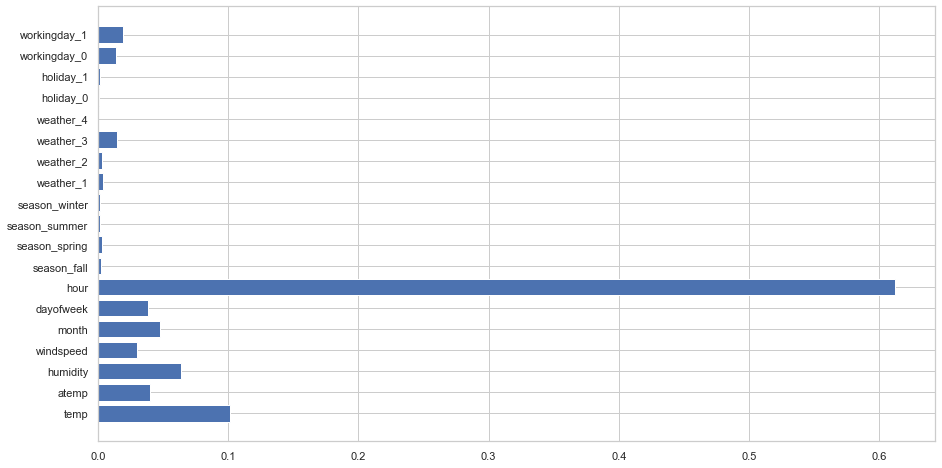

In [36]:
plt.barh(X.columns, rf.feature_importances_)

In [37]:
xgboost = xgb.XGBRegressor(random_state = 101).fit(X, y)
cv = KFold(n_splits = 10, shuffle = True)
xgb_cv = cv_metrics(xgboost, X, y, cv)
xgb_df = xgb_cv[0].rename(columns = {xgb_cv[0].columns[0]: 'Extreme Gradient Boosting'})
display(xgb_df)
concat_cv(xgb_cv)

,Extreme Gradient Boosting
Mean Absolute Error,37.5118
Root Mean Squared Error,53.6382
Accuracy,78.6359


,0,1,2,3,4,5,6,7,8,9
Mean Absolute Error,37.6751,36.4282,38.2169,38.9558,37.6272,37.5555,36.9865,37.4957,37.5899,36.5877
Root Mean Squared Error,53.7023,53.9704,50.3505,53.5568,55.5186,53.7518,52.6820,53.7745,53.9402,55.1351
Accuracy from MAPE,78.5429,79.2531,78.2343,77.8135,78.5702,78.6110,78.9351,78.6451,78.5914,79.1622


### 4.1 Making Predictions
Choosing the best three ML algorithms (Random Forest, Extreme Gradient Boosting, and K Nearest Neighbors to create predictions. Will be spliting into train/test sets to compare predictions vs actual. The real test set that was provided will be used after with the best performing model.

In [182]:
# Function that provides the metrics for all the variables def scoring(model, features, labels):
def scoring_model(model, predictions, labels):
    mae = mean_absolute_error(labels, predictions) 
    rmse = sqrt(mean_squared_error(labels, predictions)) 
    print('Model Performance: ', model) 
    print('Mean Absolute Error: {:0.4f}'.format(mae)) 
    print('Root Mean Squared Error: {:0.4f}'.format(rmse)) 
    return('')

In [183]:
# For KNN
Xnt_train, Xnt_test, ynt_train, ynt_test = train_test_split(X_nt, y_nt, test_size = 0.2, random_state = 101)

# For Random Forest, XGB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [205]:
knn = KNeighborsRegressor(n_neighbors = 10).fit(Xnt_train, ynt_train)
knn_pred = knn.predict(Xnt_test)

rf = RandomForestRegressor().fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xgboost = xgb.XGBRegressor().fit(X_train, y_train)
xgb_pred = xgboost.predict(X_test)

In [206]:
print(scoring_model(knn, knn_pred, ynt_test)) 
print(scoring_model(rf, rf_pred, y_test))
print(scoring_model(xgboost, xgb_pred, y_test))

Model Performance:  KNeighborsRegressor(n_neighbors=10)
Mean Absolute Error: 55.5761
Root Mean Squared Error: 80.4435

Model Performance:  RandomForestRegressor()
Mean Absolute Error: 39.0759
Root Mean Squared Error: 57.6559

Model Performance:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Mean Absolute Error: 37.0562
Root Mean Squared Error: 53.6481



Text(0.5, 1.0, 'Extreme Gradient Boosting')

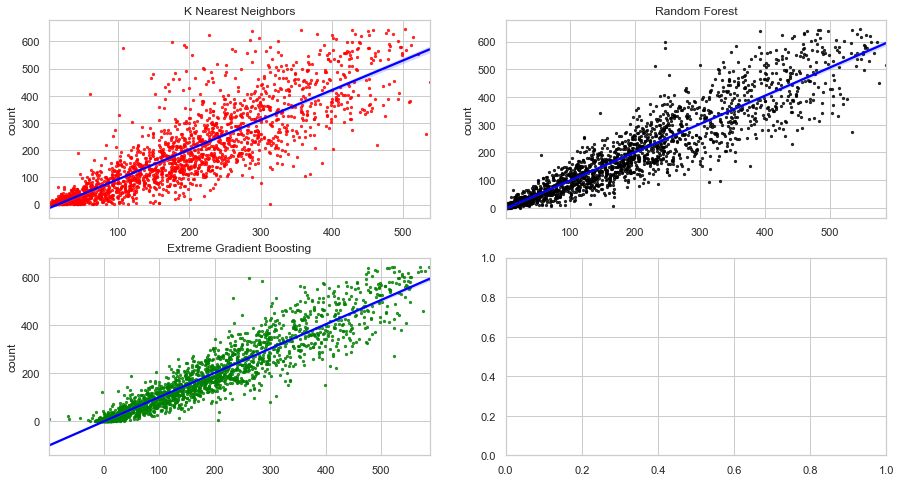

In [235]:
fig, axes = plt.subplots(2,2, figsize = (15,8), sharey = False)
sns.regplot(ax = axes[0,0], x = knn_pred, y = ynt_test,
           scatter_kws = {'s':5, 'color':'red'}, line_kws = {'color':'blue'}).set_title('K Nearest Neighbors')
sns.regplot(ax = axes[0,1], x = rf_pred, y = y_test,
            scatter_kws = {'s':5, 'color':'black'}, line_kws = {'color':'blue'}).set_title('Random Forest')
sns.regplot(ax = axes[1,0], x = xgb_pred, y = y_test,
            scatter_kws={'s':5, 'color':'green'}, line_kws = {'color':'blue'}).set_title('Extreme Gradient Boosting')

### 4.2 Final Submission Model

In [186]:
scaler_test = MinMaxScaler()
scaler_test.fit(test)
test = pd.DataFrame(scaler_test.transform(test), index = test.index, columns = test.columns)

In [195]:
xgb_test = xgb.XGBRegressor().fit(X, y)
xgb_test_pred = xgb_test.predict(test)

In [196]:
submission['count'] = xgb_test_pred

In [237]:
submission.head(24)

,datetime,count
0,2011-01-20 00:00:00,23.995781
1,2011-01-20 01:00:00,25.389078
2,2011-01-20 02:00:00,24.028482
3,2011-01-20 03:00:00,11.747864
4,2011-01-20 04:00:00,11.747864
5,2011-01-20 05:00:00,21.564503
6,2011-01-20 06:00:00,69.641487
7,2011-01-20 07:00:00,178.479874
8,2011-01-20 08:00:00,330.310028
9,2011-01-20 09:00:00,179.798630
